In [35]:
import configparser
import psycopg2

config = configparser.ConfigParser()
config.read('dwh.cfg')

conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()

In [3]:
cur.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
for table in cur.fetchall():
    cur.execute(f"drop table {table[0]}")

In [6]:
cur.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
for table in cur.fetchall():
    print(table[0])

stagingevents
stagingsongs
songplay
users
songs
artists
time


In [132]:
from sql_queries import *

In [133]:
cur.execute(staging_events_table_create)

In [134]:
cur.execute(staging_songs_table_create)

In [135]:
cur.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
for table in cur.fetchall():
    print(table[0])

stagingevents
stagingsongs


In [27]:
cur.execute(staging_events_copy)

In [8]:
print(staging_songs_copy,"\n",staging_songs_copy.replace("format JSON Auto", " json 'auto'")) 



copy StagingSongs from 's3://udacity-dend/song_data' 
    credentials 'aws_iam_role=arn:aws:iam::588274361007:role/dwhRole' 
    format JSON Auto;
 
 
copy StagingSongs from 's3://udacity-dend/song_data' 
    credentials 'aws_iam_role=arn:aws:iam::588274361007:role/dwhRole' 
     json 'auto';



In [29]:
cur.execute(staging_songs_copy.replace("format JSON Auto", " json 'auto'"))


In [81]:
pd.read_sql_query("Select * from StagingSongs limit 10",conn)

,num_songs,artist_id,artist_latitude,artist_longitude,artist_location,artist_name,song_id,title,duration,year


In [82]:
import pandas as pd

pd.read_sql_query("Select * from StagingEvents limit 10",conn)

,artist,auth,firstname,gender,iteminsession,lastname,length,level,location,method,page,registration,sessionid,song,status,ts,useragent,userid


In [136]:
pd.read_sql_query("""
select 
timestamp 'epoch' + ev.ts/1000 *INTERVAL '1 second' as start_time, 
ev.userid, 
ev.level, 
s.song_id, 
s.artist_id, 
ev.sessionid, 
ev.location, 
ev.useragent

from StagingEvents ev left join StagingSongs s
on ev.song = s.title and ev.artist = s.artist_name
where ev.page = 'NextSong'
 """,conn)

,start_time,userid,level,song_id,artist_id,sessionid,location,useragent


In [ ]:
select 
songplay_id, 
timestamp 'epoch' + ev.ts/1000 *INTERVAL '1 second' as start_time, 
ev.userid, 
ev.level, 
s.song_id, 
s.artist_id, 
ev.sessionid, 
ev.location, 
ev.useragent

from StagingEvents ev left join StagingSongs s
on ev.song = s.title and ev.artist = s.artist_name
where ev.page = "NextSong"

In [ ]:
insert into songplay(
songplay_id int primary key, 
start_time timestamp, 
user_id, 
level, 
song_id, 
artist_id, 
session_id, 
location, 
user_agent)
select 
timestamp 'epoch' + ev.ts/1000 *INTERVAL '1 second' as start_time, 
ev.userid, 
ev.level, 
s.song_id, 
s.artist_id, 
ev.sessionid, 
ev.location, 
ev.useragent
from StagingEvents ev left join StagingSongs s
on ev.song = s.title and ev.artist = s.artist_name
where ev.page = 'NextSong'


In [ ]:
songplay_table_create = ("""
    create table songplays (
        songplay_id int identity(0, 1) primary key,
        start_time timestamp not null,
        user_id int not null,
        level varchar not null,
        song_id char (18),
        artist_id char (18),
        session_id int not null,
        location varchar,
        user_agent varchar not null
    )

In [215]:
pd.read_sql_query("""select userid, max(ts) as ts from StagingEvents
group by 1
""",conn)

,userid,ts
0,52.0,1.543497e+12
1,99.0,1.542532e+12
2,43.0,1.543584e+12
3,6.0,1.543586e+12
4,25.0,1.542681e+12
...,...,...
93,21.0,1.543206e+12
94,82.0,1.543519e+12
95,5.0,1.543608e+12
96,38.0,1.543283e+12


In [220]:
pd.read_sql_query("""select s.userid, s.firstname, s.lastname, s.gender, s.level
from  StagingEvents s join (
select userid, max(ts) as ts from StagingEvents
group by 1) lastSession
on s.userid = lastSession.userid and s.ts = lastSession.ts and s.userid is not null
""",conn)

,userid,firstname,lastname,gender,level
0,52,Theodore,Smith,M,free
1,99,Ann,Banks,F,free
2,43,Jahiem,Miles,M,free
3,6,Cecilia,Owens,F,free
4,25,Jayden,Graves,M,paid
...,...,...,...,...,...
92,21,Preston,Sanders,M,free
93,82,Avery,Martinez,F,paid
94,5,Elijah,Davis,M,free
95,38,Gianna,Jones,F,free


In [32]:
conn.close()

In [33]:
!python etl.py

droping tables ...
0
1
2
3
4
5
6
Done!!!
Creating tables ...
done!!!
Loading staging tables ...
Done!!!
inserting into tables ...
0/tExecuted/tcomitted
1/tExecuted/tcomitted
2/tExecuted/tcomitted
3/tExecuted/tcomitted
4/tExecuted/tcomitted
All Done!!!


In [242]:
cur.execute(""" Select distinct timestamp 'epoch' + ts/1000 *INTERVAL '1 second' as t_s 
from 
StagingEvents
where page = 'NextSong'""")

In [246]:
cur.execute(""" Select *
from 
stagingevents
limit 10
""")

In [221]:
pd.read_sql_query("""
select * from users
""",conn)

,userid,firstname,lastname,gender,level


In [245]:
cur.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
for table in cur.fetchall():
    print(table[0])

time
stagingevents
stagingsongs
songplay
users
songs
artists


In [241]:
cur.execute("ROLLBACK")

In [225]:
cur.close()
conn.close()

In [244]:
cur.connection

<connection object at 0x7fc762327050; dsn: 'user=dwhuser password=xxx dbname=dwh host=dwhcluster.cgqhkzmsttsz.us-west-2.redshift.amazonaws.com port=5439', closed: 0>

In [248]:
pd.read_sql_query("""Select distinct timestamp 'epoch' + ts/1000 *INTERVAL '1 second' as t_s 
from 
StagingEvents
where page = 'NextSong'
""",conn)

,t_s
0,2018-11-04 00:50:03.796
1,2018-11-04 02:54:52.796
2,2018-11-04 02:58:57.796
3,2018-11-04 03:02:20.796
4,2018-11-04 04:35:52.796
...,...
6808,2018-11-29 22:53:32.796
6809,2018-11-29 22:57:22.796
6810,2018-11-29 23:02:05.796
6811,2018-11-29 23:05:13.796


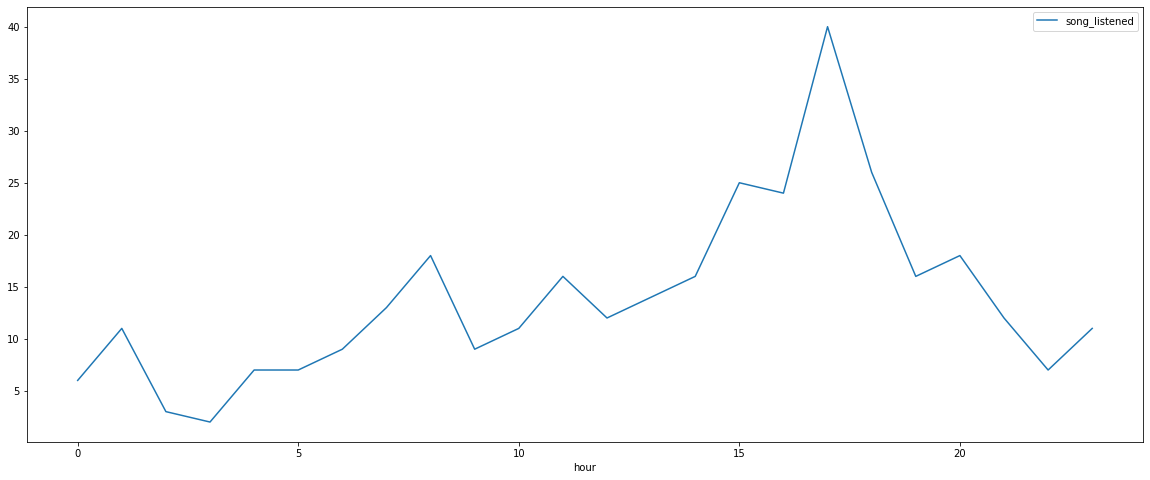

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
pd.read_sql_query(query,conn).set_index("hour").plot(figsize=(20  ,8));
plt.savefig("listining time during day.png")


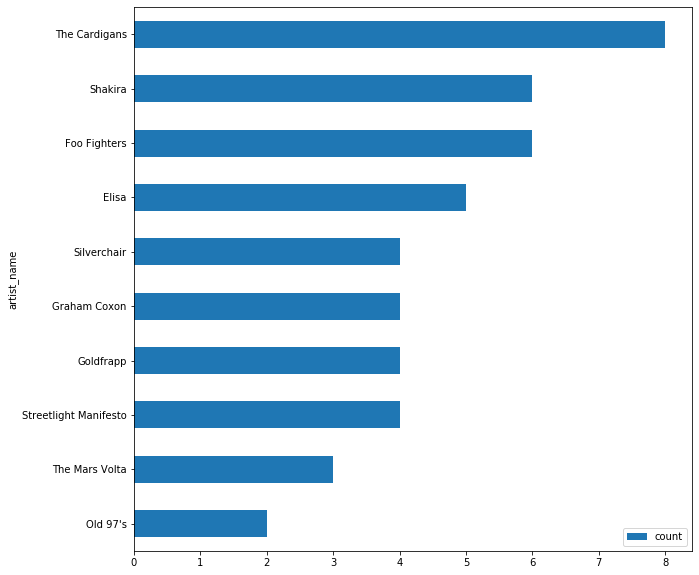

In [63]:
ax = pd.read_sql_query("""Select  a.artist_name, count(session_id)
from 
songplay sp
join
artists a
on sp.artist_id = a.artist_id
group by 1
limit 10


""",conn).sort_values("count" ,ascending=False).plot(y ="count", x ="artist_name" , kind = "barh", figsize= (10,10))
ax.invert_yaxis()

plt.savefig("top10_artisits.png")

In [39]:
pd.read_sql_query("""Select *
from 
artists
limit 10


""",conn)

,artist_id,artist_name,artist_location,artist_latitude,artist_longitude
0,ARZ5CKV1187B9AE71A,The Brand New Heavies,"London, England",51.0,0.0
1,ARN94E81187B9A124F,Soweto,,NaN,NaN
2,AR02YGA1187B9B8AC4,Bersuit Vergarabat,Buenos Aires,-34.0,-58.0
3,ARF517J1187FB4E1B8,Les Nubians,,NaN,NaN
4,AR6UYN31187B991C48,Falsalarma,Sabadell,41.0,2.0
5,ARXIQY81187B98E4ED,Jaguar Wright,,NaN,NaN
6,ARFZUMC1187B99EE8E,Jad Fair,"Ann Arbor, MI",42.0,-83.0
7,ARPKATM1187B9B76E6,Hatebreed,"New Haven, CT",41.0,-72.0
8,ARFEJTW1187B9AD987,Critical Mass,Illinois,39.0,-89.0
9,ARP1ZFY1187FB55527,Sandra,"Saarbrucken, Germany",49.0,6.0


In [55]:
x = pd.DataFrame()

In [56]:
x.plot()

<bound method DataFrame.sort_values of Empty DataFrame
Columns: []
Index: []>